In [16]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import os
import json

In [32]:
# Model
class AutoEncoder(nn.Module):
  def __init__(self, input_size, hidden_layers, out_act, **kwargs):
    super().__init__()
    # Layers
    self.layers  = nn.ModuleList()
    self.out_act = out_act
    self.out_params = kwargs
    # Encoder
    # Creating first layer
    self.num_encoding_layers = 0
    self.layers.append(nn.Linear(input_size, hidden_layers[0]))
    self.num_encoding_layers += 1
    self.layers.append(nn.BatchNorm1d(hidden_layers[0]))
    self.num_encoding_layers += 1
    # Creating other encoder layers specified in hidden_layers
    for i in range(1, len(hidden_layers)):
        self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.num_encoding_layers += 1
        self.layers.append(nn.BatchNorm1d(hidden_layers[i]))
        self.num_encoding_layers += 1
      
    # Decoder
    self.num_decoding_layers = 0
    for i in reversed(range(1, len(hidden_layers))):
        self.layers.append(nn.Linear(hidden_layers[i], hidden_layers[i-1]))
        self.num_decoding_layers += 1
        self.layers.append(nn.BatchNorm1d(hidden_layers[i-1]))
        self.num_decoding_layers += 1
    self.layers.append(nn.Linear(hidden_layers[0], input_size))
    self.num_decoding_layers += 1

  # Encoding
  def encode(self, x):
    for i in range(1, self.num_encoding_layers, 2):
        #print(self.layers[i-1])
        x = self.layers[i-1](x)
        #print(self.layers[i])
        x = self.layers[i](x)
        x = F.relu(x)
    return x

  # Decoding
  def decode(self, x):
    for i in range(1, self.num_decoding_layers-1, 2):
        #print(self.layers[i + self.num_encoding_layers - 1])
        x = self.layers[i + self.num_encoding_layers - 1](x)
        #print(self.layers[i + self.num_encoding_layers])
        x = self.layers[i + self.num_encoding_layers](x)
        x = F.relu(x)
    x = self.layers[-1](x)
    if self.out_act == 'linear':
        return x
    elif self.out_act == 'mixed' :
        x_num = self.out_params['num_act'](x[:, :self.out_params['num_features']])
        x_cat = self.out_params['cat_act'](x[:, self.out_params['num_features']:])
        x = torch.cat((x_num, x_cat), dim=1)
    else:
        return self.out_act(x)
    
  def forward(self, x):
    enc = self.encode(x)
    dec = self.decode(enc)
    return dec

In [3]:
# Dataset for tabular data
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [27]:
def train_model(model, epochs, print_every, optimizer, lr, loss_fun, location, **kwargs):
    # Saving model architecture if specified
    if 'model_architecture' in kwargs.keys():
        model_architecture = kwargs['model_architecture']
        model_architecture['out_act'] = model_architecture['out_act'].__name__
        with open('model_architecture.json', 'w') as file:
            json.dump(kwargs['model_architecture'], file)
    
    # Training on GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    # Setting optimizer
    optimizer = optimizer(model.parameters(), lr=lr)

    # Defining loss function(s)
    if not loss_fun == 'mixed':
        criterion = loss_fun
    else:
        criterion1 = kwargs['loss_fun1']
        criterion2 = kwargs['loss_fun2']

    steps = 0
    train_losses, test_losses = [], []
    test_loss_min = np.Inf

    # Training loop
    for e in range(epochs):
      running_loss = 0
      running_loss_ = 0
      for X, y in trainloader:
        steps += 1
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        if loss_fun != 'mixed':
            loss = criterion(output)
        else:
            loss1 = criterion1(output[:, :kwargs['num_features']], y[:, :kwargs['num_features']])
            loss2 = criterion2(output[:, kwargs['num_features']:], y[:, kwargs['num_features']:])
            loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_loss_ += loss.item()
    
        if steps % print_every == 0:
          print(f'Epoch {e+1}/{epochs}, Step {steps}, Train Loss: {running_loss_/print_every:.3f}')
          running_loss_ = 0
    
    
      # Model evaluation on the test data
      else:
        running_testloss = 0
        with torch.no_grad():
          model.eval()
          for X, y in testloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            if loss_fun != 'mixed':
                loss = criterion(output)
            else:
                loss1 = criterion1(output[:, :kwargs['num_features']], y[:, :kwargs['num_features']])
                loss2 = criterion2(output[:, kwargs['num_features']:], y[:, kwargs['num_features']:])
                loss = loss1 + loss2
            running_testloss += loss.item()
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(running_testloss/len(testloader))
        
        # Saving model if results improve
        if test_losses[-1] <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            test_loss_min,
            test_losses[-1]))
            torch.save(model.state_dict(), os.path.join(location, 'model.pt'))
                    
        print(f'Epoch {e+1}/{epochs}, Train Loss: {running_loss/len(trainloader):.3f}, Test Loss: {running_testloss/len(testloader()):.3f}')
    return (train_losses, test_losses)
    

In [5]:
# Creating latent space
def create_latent_space(model, dataloader):
    with torch.no_grad():
        model.eval()
        full_latent_space = []
        for X, _ in tqdm(dataloader):
            latent_space = model.encode(X)
            full_latent_space.append(latent_space)
    
        latent_space = torch.cat(full_latent_space, dim=0)
        latent_space = latent_space.numpy()
    return latent_space

# Further reducing latent space dimensinality to 2 variables if needed
def reduce_2_2var(latent_space):
    # Dimension reduction to 2 with PCA if neccesary
    if latent_space.shape[1] != 2:
        pca_2var = PCA(n_components=2)
        latent_space_2var = pca_2var.fit_transform(latent_space)
        return latent_space_2var
    else:
        return latent_space

# Clustering
def clustering(X, max_clusters, create_fig, location):
    # Function to calculate WCSS
    def calculate_wcss(X, max_clusters):
        wcss = []
        for i in range(1, max_clusters):
            kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)
        return wcss

    # Calculate WCSS for different values of k
    wcss = calculate_wcss(X, max_clusters)
    # Use KneeLocator to find the elbow point
    kneedle = KneeLocator(range(1, max_clusters), wcss, curve='convex', direction='decreasing')
    optimal_k = kneedle.elbow
    # Kmeans with the optimal number of clusters
    kmeans_actual = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
    kmeans_actual.fit(X)

    if create_fig:
        # Colormap for clustering
        cmap = cm.get_cmap('viridis', optimal_k)
        # Create figure
        f, ax = plt.subplots(2, 1, figsize=(6, 8))
        # Plot the Elbow Method graph
        ax[0].plot(range(1, 20), wcss, marker='o')
        ax[0].vlines(optimal_k, ax[0].get_ylim()[0], ax[0].get_ylim()[1], linestyles='dashed')
        ax[0].set_title('Elbow Method')
        ax[0].set_xlabel('Number of clusters')
        ax[0].set_ylabel('WCSS')
        ax[1].scatter(X[:, 0], X[:, 1], c=kmeans_actual.labels_, cmap=cmap)
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(optimal_k)]
        labels = [f'Cluster {cluster}' for cluster in range(optimal_k)]
        ax[1].legend(handles, labels, title='Cluster')
        plt.savefig(os.path.join(location, 'clustering_fig.png'))
    
    return kmeans_actual

def eval_clustering(clustering, categorical, numerical, create_fig, location):
    categorical.fillna('unknown')
    categorical['cluster'] = clustering.labels_
    numerical['cluster'] = clustering.labels_
    # Label encoding
    le = LabelEncoder()
    for col in categorical.columns:
        categorical[col] = le.fit_transform(categorical[col])

    # Calculating chi-scores on the categorical data
    chi_scores = chi2(categorical, categorical['cluster'])
    chi_values = pd.Series(chi_scores[0], index=categorical.columns)
    chi_values_sorted = chi_values.sort_values(ascending=False)
    p_values = pd.Series(chi_scores[0], index=categorical.columns)
    p_values_sorted = p_values.sort_values(ascending=False)
    chi_out = pd.DataFrame({'chi': chi_values, 'p': p_values})

    # Comparing the numerical features
    numerical_sigmas = numerical.drop(columns='cluster').var()
    numerical_relative_sigmas = [pd.DataFrame({cluster: numerical.loc[numerical['cluster'] == cluster].drop(columns=['cluster']).var() / numerical_sigmas}) 
                                 for cluster in sorted(numerical['cluster'].unique())]
    numerical_relative_sigmas = pd.concat(numerical_relative_sigmas, axis=1)
    numerical_relative_sigmas['mean'] = numerical_relative_sigmas.mean(axis=1)
    sorted_sigmas = numerical_relative_sigmas.sort_values(ascending=False, by='mean')
    
    
    if create_fig:
        f, ax = plt.subplots(1, 3, figsize=(12, 4))
        chi_values_sorted.plot.bar(ax=ax[0])
        p_values_sorted.plot.bar(ax=ax[1])
        ax[2].bar(sorted_sigmas.index, sorted_sigmas['mean'])
        ax[2].set_xticks(sorted_sigmas.index)
        ax[2].set_xticklabels(sorted_sigmas.index, rotation=90)
        plt.tight_layout()
        plt.savefig(os.path.join(location, 'chi_square.png'))

    return chi_out, numerical_relative_sigmas
    


def full_eval(model, dataloader, max_clusters, categorical, numerical, create_fig, location):
    latent_space = create_latent_space(model, dataloader)
    latent_space = reduce_2_2var(latent_space)
    clusters = clustering(latent_space, max_clusters, create_fig, location)
    num_clusters = np.unique(clusters.labels_)
    chi, sigmas = eval_clustering(clusters, categorical, numerical, create_fig, location)
    chi.to_csv(os.path.join(location, 'chi.csv'))
    sigmas.to_csv(os.path.join(location, 'sigmas.csv'))
    return num_clusters
    

In [ ]:
# Loading data
inputFeature = pd.read_csv('../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
# Separating numerical and categorical features
numerical_features=['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear']
categorical_features = ['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend']
# Onehot-encoding categorical features
inputFeature_1h = pd.get_dummies(inputFeature, columns=categorical_features)

# Convert object columns to numeric if they represent categories
for column in inputFeature_1h.select_dtypes(include=['object']):
    inputFeature_1h[column] = inputFeature_1h[column].astype('category').cat.codes

# Train-test split
train, test = train_test_split(inputFeature_1h, test_size=0.1, random_state=42)

# For latent space generation
all_data = pd.concat([train, test], axis=0).sort_index()

# Normalizing numerical features
for feature in numerical_features:
  train[feature] = (train[feature] - train[feature].min()) / (train[feature].max() - train[feature].min())
  test[feature] = (test[feature] - test[feature].min()) / (test[feature].max() - test[feature].min())

# Converting data to tensors
X_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))
y_train = torch.nan_to_num(torch.Tensor(train.values.astype(np.float32)))

X_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))
y_test = torch.nan_to_num(torch.Tensor(test.values.astype(np.float32)))

X = torch.nan_to_num(torch.Tensor(all_data.values.astype('float32')))
y = torch.nan_to_num(torch.Tensor(all_data.values.astype('float32')))

# Dataloaders
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)
dataset = MyDataset(X, y)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [33]:
# Specifying model architecture
model_architecture = {'input': 227,
                      'hidden': [128, 64, 32, 16],
                      'out_act': F.sigmoid}

model = AutoEncoder(model_architecture['input'], model_architecture['hidden'], out_act=model_architecture['out_act'])
location=''

In [34]:
train_losses, test_losses = train_model(model, epochs=20, print_every=40, optimizer=optim.Adam, 
                                        lr=0.001, loss_fun='mixed', location=location, num_features=8, loss_fun1=nn.MSELoss(), loss_fun2=nn.BCELoss(), model_architecture=model_architecture)

Epoch 1/20, Step 40, Train Loss: 0.481
Epoch 1/20, Step 80, Train Loss: 0.189
Epoch 1/20, Step 120, Train Loss: 0.137
Epoch 1/20, Step 160, Train Loss: 0.121
Epoch 1/20, Step 200, Train Loss: 0.111
Epoch 1/20, Step 240, Train Loss: 0.102
Epoch 1/20, Step 280, Train Loss: 0.098
Epoch 1/20, Step 320, Train Loss: 0.094
Epoch 1/20, Step 360, Train Loss: 0.092
Epoch 1/20, Step 400, Train Loss: 0.087


KeyboardInterrupt: 

100%|███████████████████████████████████████████████████████████████████████████████| 534/534 [00:00<00:00, 913.43it/s]
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_12016\2493354590.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', optimal_k)
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_12016\2493354590.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical['cluster'] = clustering.labels_
C:\Users\CSANADANSYS\AppData\Local\Temp\ipykernel_12016\2493354590.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy o

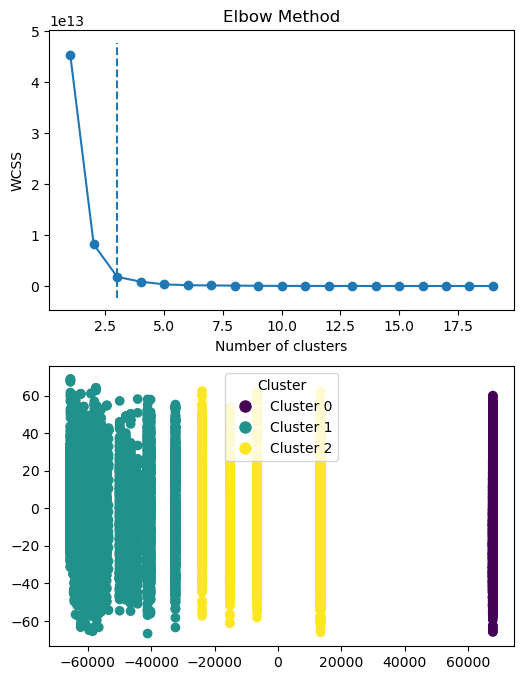

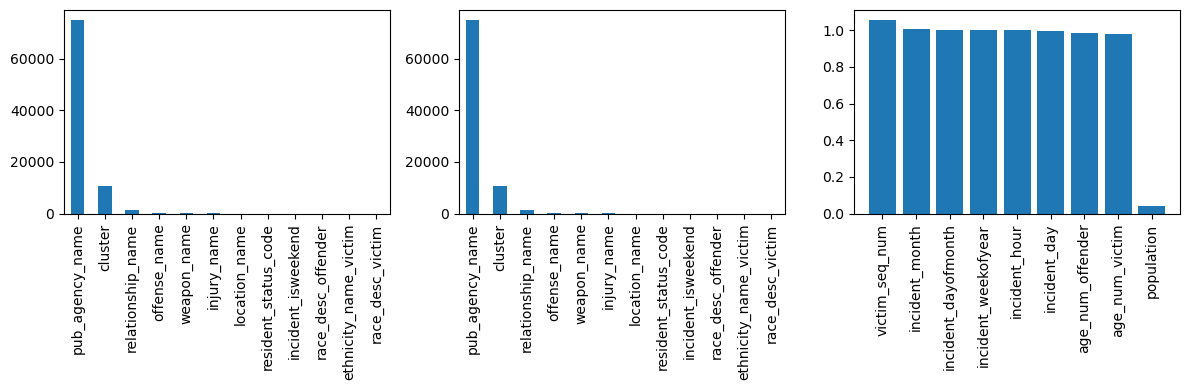

In [ ]:
ages = pd.read_csv('../../Data/NIBRS_ND_2021/processed/num_out.csv', index_col='Unnamed: 0').sort_index()
race = pd.read_csv('../../Data/NIBRS_ND_2021/processed/cat_out.csv', index_col='Unnamed: 0')
inputFeature = pd.read_csv('../../Data/NIBRS_ND_2021/processed/input.csv', index_col='Unnamed: 0')
inputFeature = inputFeature.join(ages)
inputFeature = inputFeature.join(race)
categorical = inputFeature[['resident_status_code','race_desc_victim',
'ethnicity_name_victim','pub_agency_name','offense_name','location_name','weapon_name'
,'injury_name','relationship_name','incident_isweekend', 'race_desc_offender']]
numerical = inputFeature[['population','victim_seq_num','age_num_victim','incident_hour','incident_month','incident_day','incident_dayofmonth','incident_weekofyear', 'age_num_offender']]


model = model.to('cpu')
model.load_state_dict(torch.load(os.path.join(location, 'model.pt')))
num_clusters = full_eval(model, dataloader, 20, categorical, numerical, True, '')

In [10]:
print(model)

AutoEncoder(
  (layers): ModuleList(
    (0): Linear(in_features=227, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=16, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=32, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=64, out_features=128, bias=True)
 